# Price Forecast Model

This notebook contains the exploratory data analysis, model training, and evaluation steps for the price forecasting model.

In [395]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style='whitegrid')

In [396]:
# Load the dataset
df = pd.read_csv(r'C:\Users\40108378\OneDrive - Anheuser-Busch InBev\Hedging Commodities\price-forecast-model\notebooks\Final_SAFEX_INPUT.csv')

# Display the first few rows of the dataset
df.head()

,Date,Price,volume,open_price,Year,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,year_month,max_temp,precipitation,avg_temp,min_temp,active_flag,day
0,2015-05-08,3853,657.0,3820.0,2015,11.9183,476.50,481.50,2681.0,2370.0,201505,72.32070,0.534166,59.4850,46.63575,0,Friday
1,2015-05-15,3810,41.0,3855.0,2015,11.7974,511.00,517.50,2787.0,2403.0,201505,72.32070,0.534166,59.4850,46.63575,0,Friday
2,2015-05-22,3798,154.0,3810.0,2015,11.8919,515.25,523.00,2830.0,2440.0,201505,72.32070,0.534166,59.4850,46.63575,0,Friday
3,2015-05-29,3828,364.0,3825.0,2015,12.1525,477.00,482.25,2730.0,2397.0,201505,72.32070,0.534166,59.4850,46.63575,0,Friday
4,2015-06-05,3853,356.0,3843.0,2015,12.5792,517.00,521.50,2751.0,2437.0,201506,63.05725,2.187500,51.9028,40.72700,0,Friday


In [397]:
df.shape

(322, 17)

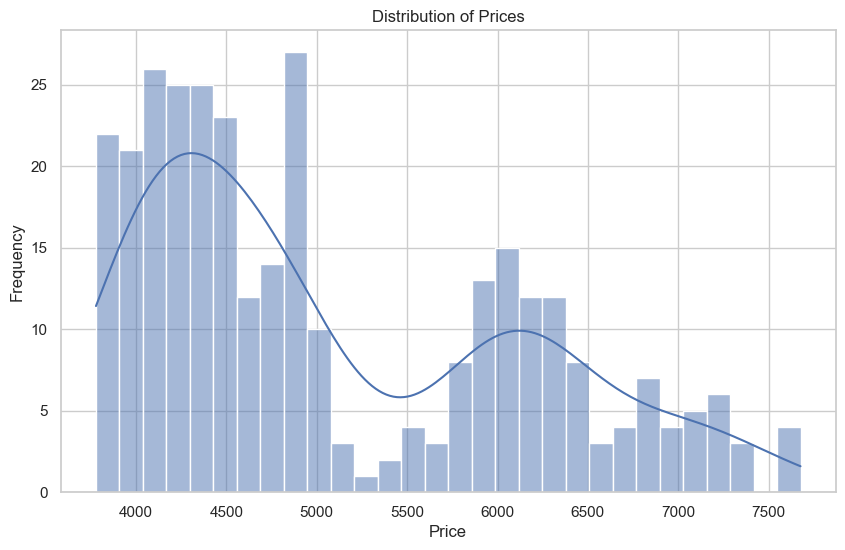

In [398]:
# Exploratory Data Analysis
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [399]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create covid_flag for data in 2020
df['covid_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2020 else 0)

# Create war_flag for data in 2022
df['war_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2022 else 0)

# Display the updated dataframe
df[['Date', 'covid_flag', 'war_flag']].head()
# Add a seasonality column based on the month
df['seasonality'] = df['Date'].dt.month % 12 // 3 + 1


# Display the updated dataframe with the new column
df[['Date', 'seasonality']].head()



,Date,seasonality
0,2015-05-08,2
1,2015-05-15,2
2,2015-05-22,2
3,2015-05-29,2
4,2015-06-05,3


In [400]:
# Add a price_diff column
df['price_diff'] = df['Price'].diff()

# Display the updated DataFrame
df.head()

,Date,Price,volume,open_price,Year,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,...,max_temp,precipitation,avg_temp,min_temp,active_flag,day,covid_flag,war_flag,seasonality,price_diff
0,2015-05-08,3853,657.0,3820.0,2015,11.9183,476.50,481.50,2681.0,2370.0,...,72.32070,0.534166,59.4850,46.63575,0,Friday,0,0,2,NaN
1,2015-05-15,3810,41.0,3855.0,2015,11.7974,511.00,517.50,2787.0,2403.0,...,72.32070,0.534166,59.4850,46.63575,0,Friday,0,0,2,-43.0
2,2015-05-22,3798,154.0,3810.0,2015,11.8919,515.25,523.00,2830.0,2440.0,...,72.32070,0.534166,59.4850,46.63575,0,Friday,0,0,2,-12.0
3,2015-05-29,3828,364.0,3825.0,2015,12.1525,477.00,482.25,2730.0,2397.0,...,72.32070,0.534166,59.4850,46.63575,0,Friday,0,0,2,30.0
4,2015-06-05,3853,356.0,3843.0,2015,12.5792,517.00,521.50,2751.0,2437.0,...,63.05725,2.187500,51.9028,40.72700,0,Friday,0,0,3,25.0


In [401]:
from lightgbm import LGBMRegressor

In [402]:
df.tail(100)

,Date,Price,volume,open_price,Year,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,...,max_temp,precipitation,avg_temp,min_temp,active_flag,day,covid_flag,war_flag,seasonality,price_diff
222,2021-11-26,6333,2571.0,6270.0,2021,16.2860,825.50,840.25,3476.0,3695.0,...,76.63280,2.506667,65.23115,53.81635,0,Friday,0,0,4,265.0
223,2021-12-03,6225,734.0,6175.0,2021,16.0809,794.50,803.75,3485.0,3741.0,...,77.15780,4.718333,67.36750,57.56480,0,Friday,0,0,1,-108.0
224,2021-12-10,6117,1044.0,6100.0,2021,15.9761,782.00,785.25,3552.0,3878.0,...,77.15780,4.718333,67.36750,57.56480,0,Friday,0,0,1,-108.0
225,2022-05-06,7067,574.0,7070.0,2022,15.9963,1097.00,1108.50,4502.0,4623.0,...,69.66535,1.169167,57.46800,45.25860,0,Friday,0,1,2,950.0
226,2022-05-13,7661,312.0,7661.0,2022,16.1652,1167.25,1177.50,4624.0,4770.0,...,69.66535,1.169167,57.46800,45.25860,0,Friday,0,1,2,594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,2024-11-29,5885,1716.0,5945.0,2024,18.0569,532.25,548.00,6325.0,4992.0,...,79.54470,1.655000,67.52555,55.49445,0,Friday,0,0,4,-73.0
318,2024-12-06,5907,1359.0,5910.0,2024,18.0255,542.50,557.25,6388.0,5036.0,...,83.90460,1.350834,72.02660,60.14195,0,Friday,0,0,1,22.0
319,2024-12-13,5794,1045.0,5800.4,2024,17.8711,526.50,552.25,6414.0,5222.0,...,83.90460,1.350834,72.02660,60.14195,0,Friday,0,0,1,-113.0
320,2024-12-20,5750,1228.0,5780.0,2024,18.3054,533.00,542.75,6794.0,5295.0,...,83.90460,1.350834,72.02660,60.14195,0,Friday,0,0,1,-44.0


In [403]:
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA

# Initialize the starting point for the loop
current_date = pd.Timestamp('2024-05-03')
horizon = 34  # Number of weeks to extrapolate

# Loop until the end of December 2023
while current_date <= pd.Timestamp('2024-12-31'):
    data_2022_2023 = df[df['Date'] < current_date]
    for i in range(0, horizon):
        # Use 20-day moving averages for extrapolation
        forecasted_values = {}
        for column in ['price_diff','volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty',
                       'WZ1 Comdty', 'YW1 Comdty', 'max_temp', 'precipitation', 'avg_temp', 'min_temp']:
            if len(data_2022_2023[column]) >= 20:
                forecasted_values[column] = data_2022_2023[column].rolling(window=120).mean().iloc[-1]
            else:
                forecasted_values[column] = data_2022_2023[column].mean()
            
            

        # Create a new row with extrapolated data
        new_row = {
            'Date': current_date + timedelta(weeks=i),
            'price_diff': forecasted_values['price_diff'],
            'volume': forecasted_values['volume'],
            'open_price': forecasted_values['open_price'],
            'USDZAR Curncy': forecasted_values['USDZAR Curncy'],
            'W 1 Comdty': forecasted_values['W 1 Comdty'],
            'W 2 Comdty': forecasted_values['W 2 Comdty'],
            'WZ1 Comdty': forecasted_values['WZ1 Comdty'],
            'YW1 Comdty': forecasted_values['YW1 Comdty'],
            'year_month': (current_date + timedelta(weeks=i)).year * 100 + (current_date + timedelta(weeks=i)).month,
            'max_temp': forecasted_values['max_temp'],
            'precipitation': forecasted_values['precipitation'],
            'avg_temp': forecasted_values['avg_temp'],
            'min_temp': forecasted_values['min_temp'],
            'active_flag': 0,
            'covid_flag': 0,
            'war_flag': 0,
            'day': 'Friday',
            'seasonality': (current_date + timedelta(weeks=i)).month % 12 // 3 + 1
        }
        # Append the new row to the dataframe
        data_2022_2023 = pd.concat([data_2022_2023, pd.DataFrame([new_row])], ignore_index=True)
    print(f"Extrapolated data until {current_date + timedelta(weeks=horizon)}")
    print(data_2022_2023.tail(horizon))
    # Prepare the data for training
    features = ['price_diff','volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty',
                'WZ1 Comdty', 'YW1 Comdty', 'max_temp', 'precipitation',
                'avg_temp', 'min_temp']
    target = 'Price'
    X_train = df[df['Date'] <= current_date][features].astype(float)
    y_train = df[df['Date'] <= current_date][target].astype(float)
    X_test = data_2022_2023[data_2022_2023['Date'] > current_date][features].astype(float)
    y_test = df[df['Date'] > current_date][target].astype(float)

    # Ensure X_test and y_test have the same length
    min_length = min(len(X_test), len(y_test))
    X_test = X_test.iloc[:min_length]
    y_test = y_test.iloc[:min_length]

    # Train the XGB model
    lgbm_model = LGBMRegressor(random_state=42, max_depth=5, n_estimators=100, learning_rate=0.2)
    # Drop NaN values from training data
    print(X_train.isnull().sum())
    print(y_train.isnull().sum())
    # Train the XGB model
    lgbm_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = lgbm_model.predict(X_test)
    print(len(y_pred))
    print(len(y_test))

    horizon_array = np.arange(1, len(y_pred) + 1)

    # Create a DataFrame for predictions
    prediction_current_date = pd.DataFrame({
        'Date': X_test.index,
        'Predicted_Price': y_pred,
        'Horizon': horizon_array
    })
    current_date_str = current_date.strftime('%Y-%m-%d')
    prediction_current_date.to_csv(f'output/predictions_{current_date_str}.csv', index=False)

    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Percentage Error: {mape * 100:.2f}%")
    current_date += timedelta(weeks=1)
    horizon -= 1


Extrapolated data until 2024-12-27 00:00:00
          Date  Price       volume   open_price  Year  USDZAR Curncy  \
288 2024-05-03    NaN   979.941667  5949.813333   NaN      16.746859   
289 2024-05-10    NaN   979.482847  5959.020111   NaN      16.741986   
290 2024-05-17    NaN   979.611871  5968.220279   NaN      16.737373   
291 2024-05-24    NaN   980.575303  5977.955448   NaN      16.734840   
292 2024-05-31    NaN   983.555097  5987.413410   NaN      16.734403   
293 2024-06-07    NaN   986.551390  5997.141855   NaN      16.734734   
294 2024-06-14    NaN   988.597651  6007.118037   NaN      16.735378   
295 2024-06-21    NaN   992.927632  6016.694021   NaN      16.732575   
296 2024-06-28    NaN   984.643695  6025.624804   NaN      16.725027   
297 2024-07-05    NaN   989.882393  6035.171677   NaN      16.719506   
298 2024-07-12    NaN   993.314746  6044.548108   NaN      16.715871   
299 2024-07-19    NaN   996.175702  6054.211009   NaN      16.716873   
300 2024-07-26    Na

ValueError: Input data must be 2 dimensional and non empty.

In [404]:
import os
# Define the directory where the prediction CSV files are stored
predictions_dir = r'output/'  # Replace with the actual directory path if different

# List all CSV files in the directory
csv_files = [file for file in os.listdir(predictions_dir) if file.startswith('predictions_') and file.endswith('.csv')]

# Initialize an empty list to store DataFrames
predictions_list = []
# Extract the date from the file name and add it as a new column
for file in csv_files:
    file_date = file.split('_')[1].split('.')[0]  # Extract the date part from the file name
    df_new = pd.read_csv(os.path.join(predictions_dir, file))
    df_new['File_Date'] = file_date  # Add the extracted date as a new column
    predictions_list.append(df_new)

# Concatenate all DataFrames into a single DataFrame
all_predictions = pd.concat(predictions_list, ignore_index=True)

# Display the combined DataFrame
print(all_predictions.head())
print(f"Total predictions loaded: {len(all_predictions)}")


   Date  Predicted_Price  Horizon   File_Date
0   289      5918.213290        1  2024-05-03
1   290      6013.643321        2  2024-05-03
2   291      6013.643321        3  2024-05-03
3   292      6013.643321        4  2024-05-03
4   293      6013.643321        5  2024-05-03
Total predictions loaded: 561


In [405]:
# Convert 'File_Date' to datetime format
all_predictions['File_Date'] = pd.to_datetime(all_predictions['File_Date'])

# Calculate the prediction date by adding the horizon in weeks
all_predictions['prediction_date'] = all_predictions['File_Date'] + pd.to_timedelta(all_predictions['Horizon'], unit='W')

# Display the updated DataFrame
print(all_predictions.head())

   Date  Predicted_Price  Horizon  File_Date prediction_date
0   289      5918.213290        1 2024-05-03      2024-05-10
1   290      6013.643321        2 2024-05-03      2024-05-17
2   291      6013.643321        3 2024-05-03      2024-05-24
3   292      6013.643321        4 2024-05-03      2024-05-31
4   293      6013.643321        5 2024-05-03      2024-06-07


In [406]:
all_predictions.drop(columns=['Date'], inplace=True)
all_predictions.rename(columns={'prediction_date': 'Date'}, inplace=True)

In [407]:
# Ensure the 'Date' column in both DataFrames is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'], errors='coerce')

# Convert the 'Date' columns to string format for matching
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
all_predictions['Date'] = all_predictions['Date'].dt.strftime('%Y-%m-%d')

# Merge the DataFrames on the 'Date' column
merged_predictions = all_predictions.merge(df[['Date', 'Price']], on='Date', how='left')

# Display the merged DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price
0      5918.213290        1 2024-05-03  2024-05-10  6319.0
1      6013.643321        2 2024-05-03  2024-05-17  6384.0
2      6013.643321        3 2024-05-03  2024-05-24  6483.0
3      6013.643321        4 2024-05-03  2024-05-31  6640.0
4      6013.643321        5 2024-05-03  2024-06-07  6518.0


In [408]:
# Map the 'File_Date' to the corresponding 'Price' from the 'df' DataFrame
merged_predictions['Trained_Price'] = merged_predictions['File_Date'].dt.strftime('%Y-%m-%d').map(
    df.set_index('Date')['Price']
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price  Trained_Price
0      5918.213290        1 2024-05-03  2024-05-10  6319.0         6193.0
1      6013.643321        2 2024-05-03  2024-05-17  6384.0         6193.0
2      6013.643321        3 2024-05-03  2024-05-24  6483.0         6193.0
3      6013.643321        4 2024-05-03  2024-05-31  6640.0         6193.0
4      6013.643321        5 2024-05-03  2024-06-07  6518.0         6193.0


In [409]:
# Calculate MAPE
merged_predictions['mape'] = abs(merged_predictions['Predicted_Price'] - merged_predictions['Price']) / merged_predictions['Price']

# Calculate Directional Accuracy
merged_predictions['dir_acc'] = merged_predictions.apply(
    lambda row: 1 if (
        (row['Price'] > row['Trained_Price'] and row['Predicted_Price'] > row['Trained_Price']) or
        (row['Price'] < row['Trained_Price'] and row['Predicted_Price'] < row['Trained_Price']) or
        (row['Price'] == row['Trained_Price'])
    ) else 0, axis=1
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price  Trained_Price  \
0      5918.213290        1 2024-05-03  2024-05-10  6319.0         6193.0   
1      6013.643321        2 2024-05-03  2024-05-17  6384.0         6193.0   
2      6013.643321        3 2024-05-03  2024-05-24  6483.0         6193.0   
3      6013.643321        4 2024-05-03  2024-05-31  6640.0         6193.0   
4      6013.643321        5 2024-05-03  2024-06-07  6518.0         6193.0   

       mape  dir_acc  
0  0.063426        0  
1  0.058013        0  
2  0.072398        0  
3  0.094331        0  
4  0.077379        0  


In [410]:
merged_predictions=merged_predictions.dropna(axis=0, how='any')

In [411]:
merged_predictions

,Predicted_Price,Horizon,File_Date,Date,Price,Trained_Price,mape,dir_acc
0,5918.213290,1,2024-05-03,2024-05-10,6319.0,6193.0,0.063426,0
1,6013.643321,2,2024-05-03,2024-05-17,6384.0,6193.0,0.058013,0
2,6013.643321,3,2024-05-03,2024-05-24,6483.0,6193.0,0.072398,0
3,6013.643321,4,2024-05-03,2024-05-31,6640.0,6193.0,0.094331,0
4,6013.643321,5,2024-05-03,2024-06-07,6518.0,6193.0,0.077379,0
...,...,...,...,...,...,...,...,...
556,6260.884890,2,2024-11-29,2024-12-13,5794.0,5885.0,0.080581,0
557,6320.129104,3,2024-11-29,2024-12-20,5750.0,5885.0,0.099153,0
558,6259.770070,1,2024-12-06,2024-12-13,5794.0,5907.0,0.080388,0
559,6259.770070,2,2024-12-06,2024-12-20,5750.0,5907.0,0.088656,0


In [412]:
# # Convert 'Date' column to datetime format if not already
# merged_predictions['Date'] = pd.to_datetime(merged_predictions['Date'])

# # Filter rows where the year in 'Date' is 2023
# merged_predictions_2023 = merged_predictions[merged_predictions['Date'].dt.year == 2023]

# # Display the filtered DataFrame
# print(merged_predictions_2023)

In [413]:
# Group by 'Horizon' and calculate the sum and count of 'dir_acc' values
horizon_dir_acc_stats = merged_predictions.groupby('Horizon')['dir_acc'].agg(['sum', 'count'])

# Calculate the percentage
horizon_dir_acc_stats['percentage'] = (horizon_dir_acc_stats['sum'] / horizon_dir_acc_stats['count']) * 100

# Average MAPE
horizon_dir_acc_stats['avg_mape'] = merged_predictions.groupby('Horizon')['mape'].mean()

# Display the result
print(horizon_dir_acc_stats)

         sum  count  percentage  avg_mape
Horizon                                  
1         13     31   41.935484  0.041415
2         15     30   50.000000  0.041708
3         15     29   51.724138  0.041793
4         15     28   53.571429  0.040799
5         13     27   48.148148  0.037849
6         12     26   46.153846  0.036704
7         11     25   44.000000  0.035751
8         10     24   41.666667  0.038868
9          9     23   39.130435  0.039928
10         9     22   40.909091  0.039492
11         8     21   38.095238  0.040297
12         7     20   35.000000  0.039354
13         8     19   42.105263  0.040072
14         8     18   44.444444  0.041352
15         9     18   50.000000  0.042706
16         9     17   52.941176  0.041693
17         9     16   56.250000  0.041768
18         8     15   53.333333  0.043582
19         8     14   57.142857  0.045280
20         8     14   57.142857  0.049250
21         7     13   53.846154  0.052231
22         7     12   58.333333  0

In [414]:
sum_dir_acc = merged_predictions['dir_acc'].sum()
print(sum_dir_acc)

264


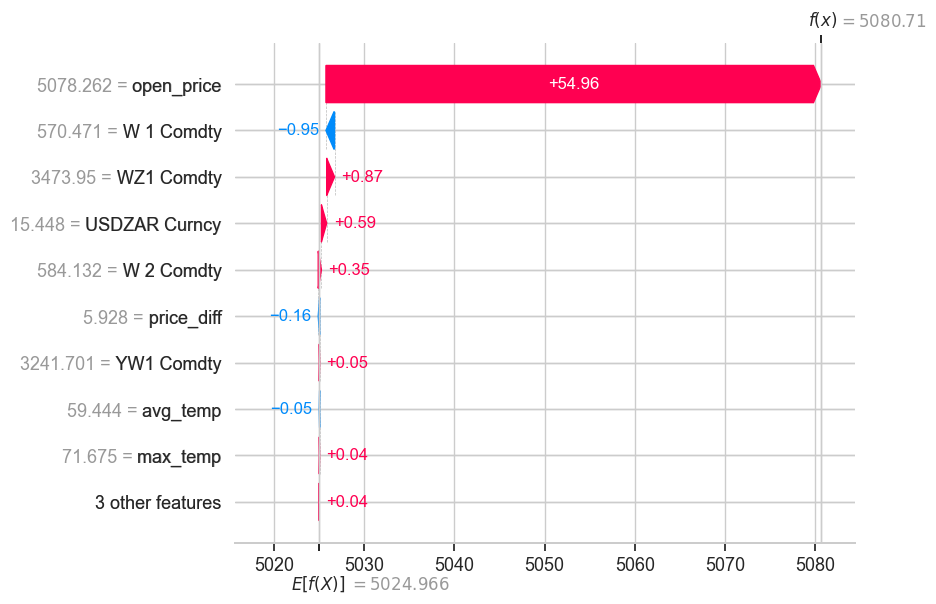

In [433]:
import shap

# Create a SHAP explainer using the trained model
explainer = shap.Explainer(lgbm_model, X_train)

# Calculate SHAP values for the training data
shap_values = explainer(X_train)

# Calculate the mean of SHAP values across all instances
mean_shap_values = shap_values.values.mean(axis=0)

# Create a SHAP explanation object for the mean values
mean_shap_explanation = shap.Explanation(
    values=mean_shap_values,
    base_values=shap_values.base_values.mean(),
    data=X_train.mean(axis=0).values,
    feature_names=X_train.columns  # Ensure feature names are included
)

# Generate the waterfall plot for the mean SHAP values with labels
shap.plots.waterfall(mean_shap_explanation, show=True)


In [434]:
from sklearn.preprocessing import MinMaxScaler

# Create a DataFrame for SHAP values
shap_df = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP Value': mean_shap_values
})

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the SHAP values
shap_df['Scaled SHAP Value'] = scaler.fit_transform(shap_df[['SHAP Value']])

# Display the scaled SHAP values
print(shap_df)

          Feature  SHAP Value  Scaled SHAP Value
0      price_diff   -0.156903           0.014219
1          volume    0.028255           0.017531
2      open_price   54.959851           1.000000
3   USDZAR Curncy    0.588244           0.027546
4      W 1 Comdty   -0.951911           0.000000
5      W 2 Comdty    0.350634           0.023296
6      WZ1 Comdty    0.869304           0.032573
7      YW1 Comdty    0.045535           0.017840
8        max_temp    0.043111           0.017796
9   precipitation    0.034120           0.017635
10       avg_temp   -0.045054           0.016219
11       min_temp   -0.021050           0.016649


In [429]:
shap_df.to_csv('output/shap_values.csv', index=False)

In [435]:
shap_df.drop(columns=['Scaled SHAP Value'], inplace=True)

In [436]:
shap_df

,Feature,SHAP Value
0,price_diff,-0.156903
1,volume,0.028255
2,open_price,54.959851
3,USDZAR Curncy,0.588244
4,W 1 Comdty,-0.951911
5,W 2 Comdty,0.350634
6,WZ1 Comdty,0.869304
7,YW1 Comdty,0.045535
8,max_temp,0.043111
9,precipitation,0.034120
